# A Simple Introduction to Tensorflow

In [1]:
import tensorflow as tf 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd 
import sys
%matplotlib inline

## First, we will implement some simple capabilities of NumPy
### Our first task is to make a set of noisy input data

In [2]:
def what_our_data_should_look_like():
    def noisy_line(x, noise):
        return -6.7 * x + 2 + noise

    arr = np.zeros((100,2))
    for i in range(100):
        x_hat = np.random.uniform(-10, 10)
        noise_hat = np.random.uniform(-1, 1)
        arr[i] = (x_hat, noisy_line(x_hat, noise_hat))

    x,y = arr.T 

    return x, y

In [3]:
tf.reset_default_graph()

#initialize our m and b
m = tf.constant(-6.7, dtype=tf.float32, name='m')
b = tf.constant(2., name='b') # also tf.float32 implicitly

#Initialize spots for the input, output, and amount of noise.
x = tf.placeholder(tf.float32, shape=[None,], name='x')
noise = tf.placeholder(tf.float32, shape=[None,], name='noise')

#Start the session.
sess = tf.Session()
init = tf.global_variables_initializer()

#This is the function that we'll pass x into to give it some noise.
with tf.name_scope('generation') as scope:
    generate_noisy_data = m * x + b + noise

#The x and noise vectors we choose to pass in
input_x = np.random.uniform(low=-10,high=10,size=100)
input_noise = np.random.uniform(low=-1,high=1,size=100)

#This is calculated with our 'generate_noisy_data' node
output_y = sess.run(generate_noisy_data, {x: input_x, noise: input_noise})

### Now we check to make sure it's good (we could do this with tensorboard, but we haven't learned that yet)

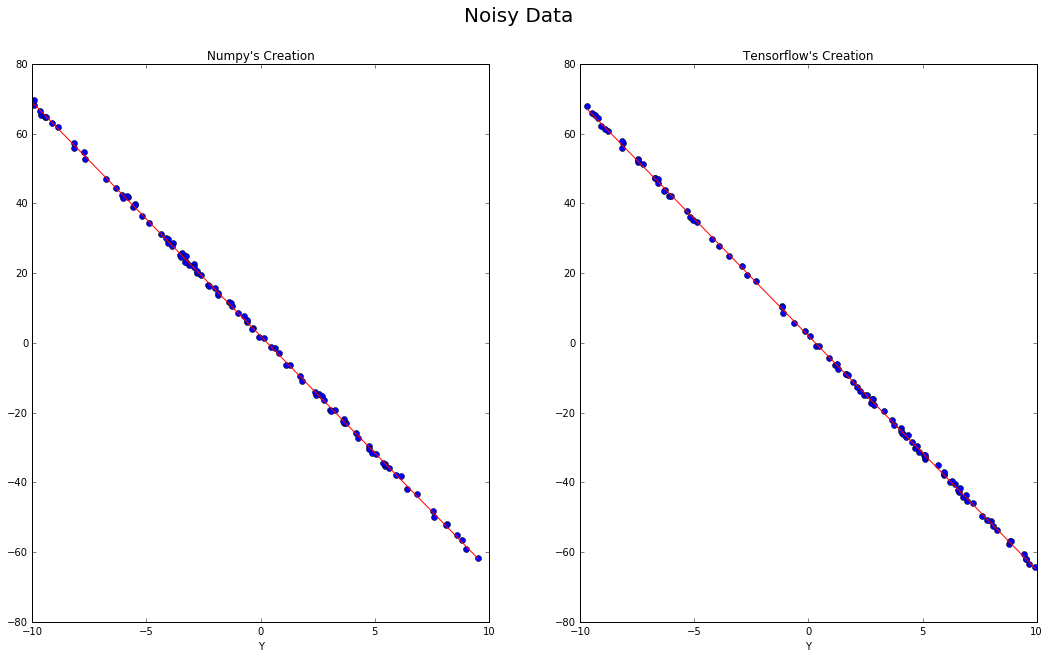

In [4]:
x_real, y_real = what_our_data_should_look_like()

plt.figure(figsize=(18,10))

plt.subplot(121)
plt.plot(x_real, y_real, 'bo')

x_real_space = np.linspace(np.min(x_real), np.max(x_real), 10)
z1 = np.polyfit(x_real, y_real, 1)
f1 = np.poly1d(z1)
plt.plot(x_real_space, f1(x_real_space), 'r')
plt.title('Numpy\'s Creation')
plt.xlabel('X')
plt.xlabel('Y')


plt.subplot(122)
plt.plot(input_x, output_y, 'bo')

x_space = np.linspace(np.min(input_x), np.max(input_x), 10)
z2 = np.polyfit(input_x, output_y, 1)
f2 = np.poly1d(z2)
plt.plot(x_space, f2(x_space), 'r')
plt.title('Tensorflow\'s Creation')
plt.xlabel('X')
plt.xlabel('Y')


plt.suptitle('Noisy Data', fontsize=20)
plt.show()

## Now we're going to make a graph that gives us a line of best fit.

### Here's what it's supposed to do:

In [5]:
def what_m_and_b_should_be():
    def noisy_line(x, noise):
        return -6.7 * x + 2 + noise


    class Regression:
        def __init__(self):
            self.learning_rate = 0.005
            self.m = 0.1
            self.b = 0.1

        def learn(self, datum):
            x_hat, target = datum
            self.m += self.delta(x_hat, target) * x_hat
            self.b += self.delta(x_hat, target) * 1.0

        def delta(self, x_hat, target):
            net = self.m * x_hat + self.b
            return self.learning_rate * (target - net)


    regresion_model = Regression()

    for _ in range(1000):
        x_hat = np.random.uniform(-10, 10)
        noise_hat = np.random.uniform(-1, 1)
        y_hat = noisy_line(x_hat, noise_hat)

        regresion_model.learn((x_hat, y_hat))

    return regresion_model.m, regresion_model.b

### Here is the Tensorflow implementation of the same operation

In [6]:
with tf.Graph().as_default():

    #----- Define the computation graph --------#

    x_hat = tf.placeholder(tf.float32, shape=None, name='x_hat') #We'll read these in one at a time.
    target = tf.placeholder(tf.float32, shape=None, name='target')

    m = tf.Variable(0.1, dtype=tf.float32, name='m')
    b = tf.Variable(0.1, dtype=tf.float32, name='b')

    learning_rate = tf.constant(0.005, name='learning_rate')

    net = m*x_hat + b
    delta_func = learning_rate * (target - net)

    #update m
    assigned_m = m.assign(m + delta_func*x_hat)
    #update b
    assigned_b = b.assign(b + delta_func*1.0)

    #------------------------------------------#


    #------- Now run it -------#
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    writer = tf.summary.FileWriter("path_to_folder", sess.graph)

    for i in range(1000):
        x_new = np.random.uniform(-10,10)
        noise = np.random.uniform(-1,1)
        #Feed_dict only needs to instantiate placeholders
        m_tens, b_tens = sess.run([assigned_m, assigned_b], {target:-6.7*x_new + 2. + noise, x_hat:x_new})
    #--------------------------#


    writer.close()

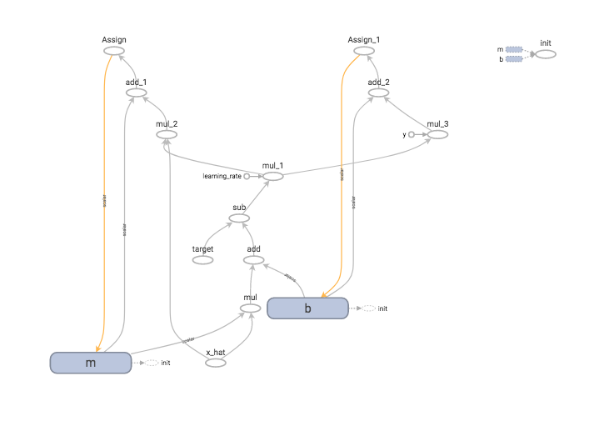

In [7]:
comp1 = plt.imread('computation_graph1.png')
plt.figure(figsize=(10,10))
plt.imshow(comp1)
plt.axis('off')
plt.show()


### Compare Tensorflow's results to the Regression class's results

In [8]:
m_real, b_real = what_m_and_b_should_be()
print("The regression class guesses the line is: y =\t{}*x + {}".format(m_real, b_real))
print("Tensorflow guesses the line is:\t\t  y =\t{}*x + {}".format(m_tens, b_tens))

The regression class guesses the line is: y =	-6.69992711131*x + 1.94464835209
Tensorflow guesses the line is:		  y =	-6.70562028885*x + 2.03804326057


## Now we extend this model to include arbitrary dimensions of X

In [9]:
def noisy_line(x, noise):
    assert len(x.shape) == 1 and x.shape[0] == 2
    beta = [-2.3, 4.5, 9.4]
    x = np.append(x, [1])
    return np.dot(beta, x) + noise
 
class Regression:
    def __init__(self):
        self.learning_rate = 0.005
        self.beta = np.zeros(3)

    def learn(self, datum):
        x_hat, target = datum
        x_hat = np.append(x_hat, [1])
        self.beta += self.delta_w(x_hat, target)

    def delta_w(self, x_hat, target):
        net = np.dot(x_hat, self.beta) # self.m * x_hat + self.b
        return self.learning_rate * (target - net) * x_hat


regresion_model = Regression()
 
for _ in range(1000):
    x_hat = np.random.uniform(-10, 10, size=(2,))
    noise_hat = np.random.uniform(-1, 1)
    y_hat = noisy_line(x_hat, noise_hat)

    regresion_model.learn((x_hat, y_hat))

In [10]:
with tf.Graph().as_default():
    #----- generate data -----#

    #initialize our m and b

    real_beta = tf.constant([-2.3, 4.5, 9.4], dtype=tf.float32, name='real_beta')

    #Initialize spots for the input, output, and amount of noise.
    x_multid = tf.placeholder(tf.float32, shape=[3,], name='x_multid')
    noise_multid = tf.placeholder(tf.float32, shape=[1,], name='noise_multid')

    #This is the function that we'll pass x into to give it some noise.
    generate_beta_data = tf.reduce_sum(tf.multiply(x_multid, real_beta)) + noise_multid

    #----- generate data -----#


    #----- Define the computation graph --------#
    target_multid = tf.placeholder(tf.float32, None, name='target_multid')

    beta = tf.Variable(0.1*np.ones(3), dtype=tf.float32, name='new_beta')

    learning_rate = tf.constant(5e-3)

    #delta_func = learning_rate * (target - tf.reduce_sum(tf.multiply(beta, x_multid)))
    #update m
    assigned_beta = beta.assign(beta + learning_rate * (target_multid - tf.reduce_sum(tf.multiply(x_multid, beta)))*x_multid)

    #------------------------------------------#


    #Implement
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for _ in xrange(1000):    
        #------ NumPy stuff ------#

        #The x and noise vectors we choose to pass in
        input_x_multid = np.random.uniform(low=-10, high=10, size=2)
        input_noise_multid = [np.random.uniform(low=-1, high=1)] #Needs brackets around it to give it shape (1,)
        input_x_multid_with_bias = np.append(input_x_multid, [1]) #This line takes a long time.

        #------ NumPy stuff ------#    



        #----- Now run the data-generation session -----#

        #This is calculated with our 'generate_noisy_data' node
        output_y_multid = sess.run(generate_beta_data, feed_dict={x_multid: input_x_multid_with_bias, noise_multid: input_noise_multid})
        #----- Now run the data-generation session -----#

    #     print output_y_multid.dtype, output_y_multid.shape
        #Now with the data we want, we can figure out the pattern 
        # (pretending we don't know about the real_beta we used to generate this data)

        beta_tens, _ = sess.run([beta, assigned_beta], 
                                feed_dict={target_multid: output_y_multid, x_multid: input_x_multid_with_bias})

    writer = tf.summary.FileWriter("path_to_folder", sess.graph)
    
writer.close()

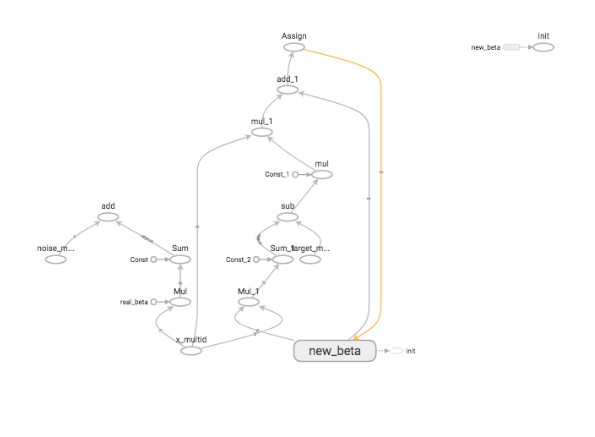

In [11]:
comp2 = plt.imread('computation_graph2.png')
plt.figure(figsize=(10,10))
plt.imshow(comp2)
plt.axis('off')
plt.show()

In [12]:
print("Regression model guesses beta is: {}".format(regresion_model.beta))
print("Tensorflow guesses beta is: \t  {}".format(beta_tens))

Regression model guesses beta is: [-2.36726203  4.4852967   9.28100157]
Tensorflow guesses beta is: 	  [-2.24287152  4.51036453  9.36961842]


# Task 4 - foo.csv

In [13]:
#Simplified computation graph
x_multid = tf.placeholder(tf.float32, shape=[3,], name='x_multid')
target_multid = tf.placeholder(tf.float32, None, name='target_multid')

beta = tf.Variable(0.1*np.ones(3), dtype=tf.float32, name='beta')

learning_rate = tf.constant(5e-3)

#update beta
assigned_beta = beta.assign(beta + learning_rate * (target_multid - tf.reduce_sum(tf.multiply(x_multid, beta)))*x_multid)



df = pd.read_csv('foo.csv')
X, Y = df[['x1','x2']].values, df[['y']].values


sess = tf.Session()
sess.run(tf.global_variables_initializer())
for ind, i in enumerate(X):
    b = np.append(i,[1])
    
    beta_tens, _ = sess.run([beta, assigned_beta], 
                            feed_dict={target_multid: Y[ind], x_multid: b})


print "I guess that the equation of y is:"
print "y = {0}*x1 + {1}*x2 + {2}".format(beta_tens[0], beta_tens[1], beta_tens[2])


I guess that the equation of y is:
y = -7.79051303864*x1 + 2.69586443901*x2 + 0.839014112949
